# Import Libraries

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import seaborn as sns 
import lightgbm as lgb 
%load_ext autoreload
%autoreload 2

In [3]:
from choices import param_dict 
from utilities import deets

# Load data

In [4]:
x = pd.read_csv('compiled_data_v3/x_phot_minmax.csv' , index_col='name')
x_col = x.columns.to_list()
i = pd.read_csv('compiled_data_v3/id_frame.csv' , index_col='name')
df = pd.merge(i,x , left_index =True , right_index =True )
df = df[df['offset']<1.01]
feat_to_drop = np.unique(param_dict['hardness'] + param_dict['IRAC']+[
    '0p5_2csc' , '2-10 keV (XMM)' , '1_2_csc' , '0p5_8_csc'
]+['var_inter_hard_prob_hs', 'ks_intra_prob_b', 'var_inter_hard_sigma_hm', 'var_inter_hard_prob_ms', 'var_inter_hard_prob_hm',] +['gal_l2', 'gal_b2'])


classes = ['AGN' ,'STAR' ,'YSO' ,'HMXB' , 'LMXB' , 'ULX' ,'CV' , 'PULSAR']
df = df[df['class'].isin(classes)]
#from sklearn.preprocessing import LabelEncoder
#y_int = LabelEncoder().fit_transform(df['class'])
deets(df,1)
u = pd.read_csv('compiled_data_v3/x_phot_minmax-unid-var-src.csv' , index_col='name')
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
x = df[x_col]
x = x.drop(columns=feat_to_drop)
x.columns = x.columns.str.replace(' ' ,'_' , regex=False)
y = df['class']
deets(x)
deets(u)

_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 73
------------------------------


STAR      2790
AGN       2395
YSO       1149
HMXB       748
ULX        211
CV         166
LMXB       143
PULSAR     101
Name: class, dtype: int64

_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 7703
Number of Columns : 39
_____________________________________________________
_____________________________________________________
------------------------------
Number of Objects : 39893
Number of Columns : 39
_____________________________________________________


## Loss Function

In [ ]:
def focal_loss_lgb(y_pred, dtrain, alpha, gamma):
	a,g = alpha, gamma
	y_true = dtrain.label
	def fl(x,t):
		p = 1/(1+np.exp(-x))
		return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
	partial_fl = lambda x: fl(x, y_true)
	grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
	hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
	return grad, hess

In [5]:
def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma):
	a,g = alpha, gamma
	y_true = dtrain.label
	p = 1/(1+np.exp(-y_pred))
	loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
	return 'focal_loss', np.mean(loss), False

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test , y_train , y_test = train_test_split(x,y , test_size = 0.2 , stratify=y)

focal_loss = lambda x,y: focal_loss_lgb(x, y, 0.25, 1.)
eval_error = lambda x,y: focal_loss_lgb_eval_error(x, y, 0.25, 1.)
lgbtrain = lgb.Dataset(x_train, y_train, free_raw_data=True)
lgbeval = lgb.Dataset(x_test, y_test)
params  = {'learning_rate':0.1, 'num_boost_round':10}
model = lgb.train(params, lgbtrain, valid_sets=[lgbeval], fobj=focal_loss, feval=eval_error )

## Cross validation

In [89]:
from utilities import simple_cv
param = {
    'objective': 'binaryclass',
    'num_class':len(np.unique(y)),
    'metric': ['auc_mu' , ] , 
    'verbosity' : 2 , 
    'deterministic' : True  , 
    'early_stopping_round' : 20 , 
    'sparse' : True , 
    'is_unbalance' : True
    }
l = len(y_train)
cl_weight = {}
cl_dict = y_train.value_counts().to_dict()
for cl , val in zip(cl_dict.keys() , cl_dict.values()):
    w = np.exp((l / val)*0.09)
    cl_weight[cl] = w
cl_weight


{'STAR': 1.2820594649453247,
 'AGN': 1.3356883328329183,
 'YSO': 1.8284347681624522,
 'HMXB': 2.527906031090322,
 'ULX': 26.616689970780907,
 'CV': 64.70085628321034,
 'LMXB': 129.63681917019255,
 'PULSAR': 940.7398749439147}

In [ ]:
clf = lgb.LGBMClassifier(n_estimators=100 ,class_weight = cl_weight , objective= 'multiclass', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
res_arr = []
from tqdm import tqdm
for i in tqdm(range(1)):
    res = simple_cv(x,y ,model=clf , k=10 , normalize_prob=0)
    print(res['class_scores'].to_markdown())
    res_arr.append(res)

  0%|          | 0/1 [00:00<?, ?it/s]

>>> GOING for 1 / 10 Iteration FOLD
>>> GOING for 2 / 10 Iteration FOLD
>>> GOING for 3 / 10 Iteration FOLD
>>> GOING for 4 / 10 Iteration FOLD
>>> GOING for 5 / 10 Iteration FOLD
>>> GOING for 6 / 10 Iteration FOLD


  0%|          | 0/1 [00:55<?, ?it/s]


KeyboardInterrupt: 

In [91]:
clf = lgb.LGBMClassifier(n_estimators=300 ,class_weight = cl_weight , objective= 'multiclassova', sparse=True , is_unbalance=True , metric=['auc_mu'] ,verbosity = 0 , random_state=42 , num_class=len(np.unique(y)) ,force_col_wise=True)
res_arr_ova = []
from tqdm import tqdm
#for i in tqdm(range(10)):
res = simple_cv(x,y ,model=clf , k=10 , normalize_prob=0)
print(res['class_scores'].to_markdown())
res_arr_ova.append(res)

>>> GOING for 1 / 10 Iteration FOLD
>>> GOING for 2 / 10 Iteration FOLD
>>> GOING for 3 / 10 Iteration FOLD
>>> GOING for 4 / 10 Iteration FOLD
>>> GOING for 5 / 10 Iteration FOLD
>>> GOING for 6 / 10 Iteration FOLD
>>> GOING for 7 / 10 Iteration FOLD
>>> GOING for 8 / 10 Iteration FOLD
>>> GOING for 9 / 10 Iteration FOLD
>>> GOING for 10 / 10 Iteration FOLD
| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.924843 |          0.943758 |   0.934205 |
| CV      |       0.313253 |          0.409449 |   0.354949 |
| HMXB    |       0.717914 |          0.640811 |   0.677175 |
| LMXB    |       0.461538 |          0.573913 |   0.511628 |
| PULSAR  |       0.227723 |          0.2875   |   0.254144 |
| STAR    |       0.913262 |          0.921186 |   0.917207 |
| ULX     |       0.530806 |          0.457143 |   0.491228 |
| YSO     |       0.853786 |          0.827848 |   0.840617 |


In [72]:
score_df_ova2 = pd.concat([el['class_scores'] for el in res_arr_ova]).reset_index().sort_values(by='recall_score')
score_df_ova2.to_csv('temp_res_comp/scores/LightGBM-ovaclass-w-0.09-without-gal-coord.csv')

In [18]:
score_df_ova = pd.concat([el['class_scores'] for el in res_arr_ova]).reset_index().sort_values(by='recall_score')
score_df_ova.to_csv('temp_res_comp/scores/LightGBM_ovaclass_w-0.05.csv')

In [ ]:
#score_df = pd.concat([el['class_scores'] for el in res_arr]).reset_index().sort_values(by='recall_score')
#score_df.to_csv('temp_res_comp/scores/LightGBM_allclass.csv')
score_df= pd.read_csv('temp_res_comp/scores/LightGBM-allclass.csv')
score_df

,Unnamed: 0,class,recall_score,precision_score,f1_score
0,12,PULSAR,0.45,0.38,0.41
1,52,PULSAR,0.45,0.37,0.40
2,20,PULSAR,0.46,0.37,0.41
3,28,PULSAR,0.47,0.39,0.43
4,60,PULSAR,0.48,0.38,0.42
...,...,...,...,...,...
75,56,AGN,0.97,0.97,0.97
76,0,AGN,0.97,0.97,0.97
77,64,AGN,0.97,0.97,0.97
78,40,AGN,0.97,0.97,0.97


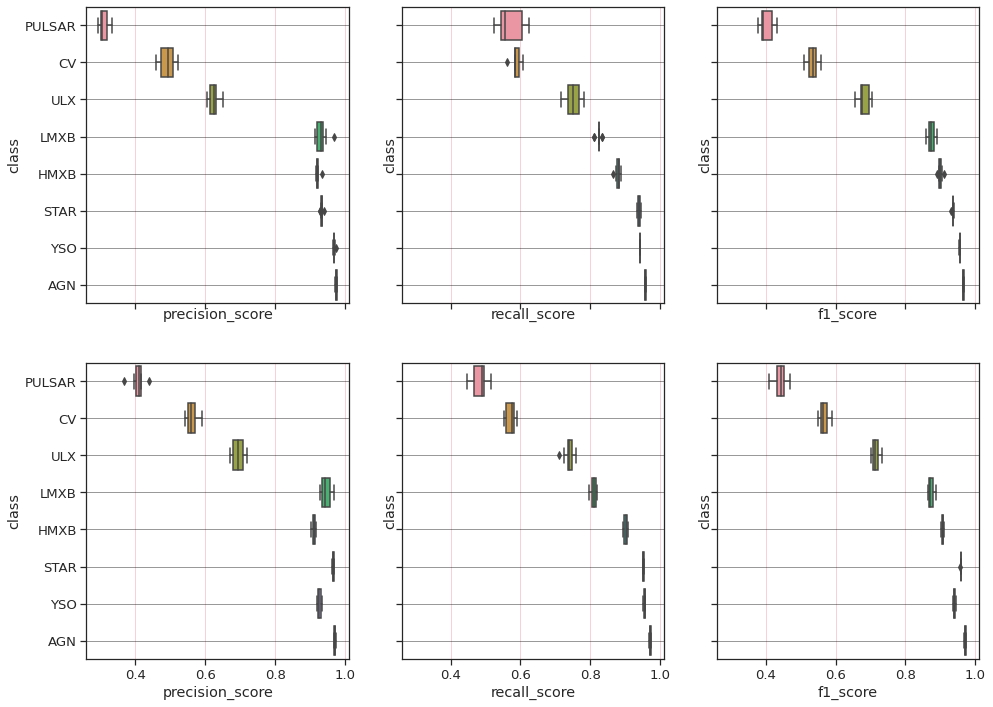

In [ ]:
fig , ax = plt.subplots(nrows=2 , ncols=3 , sharey=True ,sharex=True ,  figsize= (16,12))
sns.set_palette('vlag')
sns.boxplot(data = score_df_ova2 ,  y = 'class' , x = 'precision_score' , ax=ax[0][0])
sns.boxplot(data = score_df_ova2 ,  y = 'class' , x = 'recall_score' , ax=ax[0][1])
sns.boxplot(data = score_df_ova2 ,  y = 'class' , x = 'f1_score' , ax=ax[0][2])

sns.boxplot(data = score_df_ova ,  y = 'class' , x = 'precision_score' , ax=ax[1][0])
sns.boxplot(data = score_df_ova ,  y = 'class' , x = 'recall_score' , ax=ax[1][1])
sns.boxplot(data = score_df_ova ,  y = 'class' , x = 'f1_score' , ax=ax[1][2])
for ai in ax:
    for a in ai:
        a.yaxis.grid(True, color ="black" , alpha=0.4)
        a.xaxis.grid(True , color='crimson' , alpha=0.2)
#plt.savefig()
plt.show()

In [19]:
res['res_table']

,true_class,pred_class,pred_prob,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J183122.4-621642,STAR,STAR,0.999893,0.000011,3.115960e-06,0.000802,0.000013,0.000009,0.999893,0.000002,0.000002
2CXO J091432.7+561238,STAR,STAR,0.999436,0.001137,5.217488e-07,0.000114,0.000004,0.000004,0.999436,0.000002,0.000002
2CXO J213701.3+572446,STAR,STAR,0.996884,0.000021,3.568341e-04,0.000049,0.000004,0.000227,0.996884,0.000125,0.000003
2CXO J180935.6-255553,STAR,STAR,0.999765,0.000003,1.891440e-05,0.000006,0.000025,0.000008,0.999765,0.000002,0.000005
2CXO J100038.3+013708,AGN,AGN,0.583731,0.583731,9.758183e-05,0.000011,0.000228,0.000112,0.000081,0.001313,0.000003
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J133952.0-313859,HMXB,HMXB,0.999359,0.000735,7.761753e-03,0.999359,0.000009,0.028662,0.000427,0.000030,0.000002
2CXO J180223.5-230023,YSO,YSO,0.999825,0.000030,1.412598e-04,0.000011,0.000075,0.000257,0.002982,0.000016,0.999825
2CXO J022233.4+422026,ULX,CV,0.540499,0.000121,5.404986e-01,0.039702,0.009500,0.000002,0.001100,0.004956,0.000003


In [21]:
clf = res['clf']

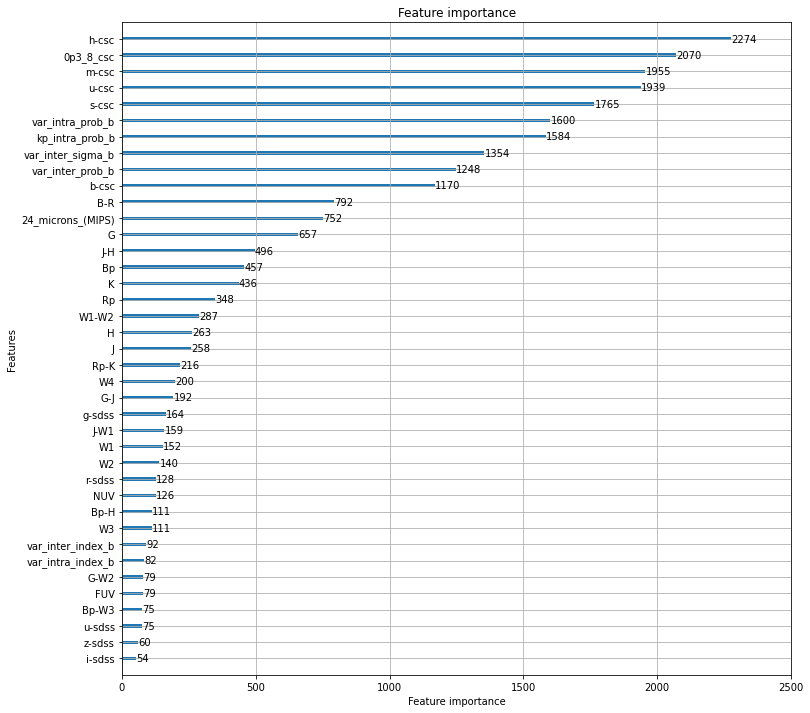

In [73]:
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize=(12,12))
lgb.plot_importance(clf , ax=ax)
plt.show()

In [74]:
import joblib

# save model
joblib.dump(clf, 'models/lgb-ova-no-gal.pkl')


['models/lgb-ova-no-gal.pkl']

In [75]:
pd.options.display.float_format = '{:,.2f}'.format
class_scores = res['class_scores']
print(class_scores.to_markdown())

| class   |   recall_score |   precision_score |   f1_score |
|:--------|---------------:|------------------:|-----------:|
| AGN     |       0.901879 |          0.957447 |   0.928833 |
| CV      |       0.415663 |          0.285124 |   0.338235 |
| HMXB    |       0.574866 |          0.659509 |   0.614286 |
| LMXB    |       0.58042  |          0.419192 |   0.486804 |
| PULSAR  |       0.425743 |          0.177686 |   0.250729 |
| STAR    |       0.88853  |          0.935825 |   0.911565 |
| ULX     |       0.578199 |          0.398693 |   0.471954 |
| YSO     |       0.830287 |          0.823834 |   0.827048 |


Text(0.5, 1.0, 'CF for LighgGBM,')

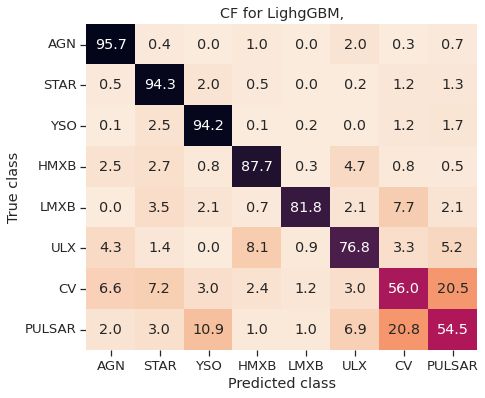

In [46]:
from utilities import plot_cf
plot_dict_def = {
    'title' : False , 
    'font_scale' : 1.2 ,
    'cbar' : False ,
    'plot_num' : 0,
}
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize=(7,6))
plot_cf([res['res_table']] , plot_dict=plot_dict_def , confidance=0. , ax=ax)
plt.title('CF for LighgGBM,')
#plt.savefig('temp_res_comp/cf/lightGBM_rf.png')

In [54]:
res['res_table'].to_csv('temp_res_comp/train_prob/lightGBM_none.csv')

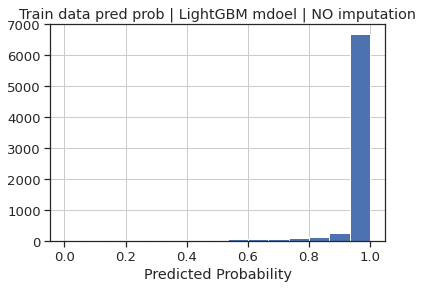

In [48]:
plt.hist(res['res_table']['pred_prob'] , bins=15)
plt.title('Train data pred prob | LightGBM mdoel | NO imputation')
plt.xlabel('Predicted Probability')
plt.savefig('temp_res_comp/train_prob_dist/LightGBM_prob.jpg')
plt.show()

## Prediction on New sources

In [76]:
# load model
import joblib
clf = joblib.load('models/lgb-ova-no-gal.pkl')
clf 

LGBMClassifier(class_weight={'AGN': 1.3356883328329183, 'CV': 64.70085628321034,
                             'HMXB': 2.527906031090322,
                             'LMXB': 129.63681917019255,
                             'PULSAR': 940.7398749439147,
                             'STAR': 1.2820594649453247,
                             'ULX': 26.616689970780907,
                             'YSO': 1.8284347681624522},
               force_col_wise=True, is_unbalance=True, metric=['auc_mu'],
               num_class=8, objective='multiclassova', random_state=42,
               sparse=True, verbosity=0)

In [77]:
u = []
ui = []
for i in range(8):
    u.append(pd.read_csv(f'compiled_data_v3/unid-non-var-chunks/x-chunk-{i}.csv' , index_col='name'))
    ui.append(pd.read_csv(f'compiled_data_v3/unid-non-var-chunks/id-chunk-{i}.csv' , index_col='name'))
u = pd.concat(u)
ui = pd.concat(ui)
u = u.drop(columns=feat_to_drop)
u.columns = u.columns.str.replace(' ' ,'_' , regex=False)
u

,var_inter_prob_b,var_inter_sigma_b,var_intra_prob_b,var_inter_index_b,kp_intra_prob_b,var_intra_index_b,h-csc,b-csc,m-csc,s-csc,...,Rp,B-R,G-J,G-W2,Bp-H,Bp-W3,Rp-K,J-H,J-W1,W1-W2
name,,,,,,,,,,,,,,,,,,,,,
2CXO J003935.9-732725,nan,nan,2.81,nan,8.72,0.00,0.00,0.00,0.00,0.01,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2CXO J003936.7-731249,nan,nan,5.27,nan,3.25,0.00,nan,0.02,0.00,0.01,...,8.75,2.63,nan,nan,nan,nan,nan,nan,nan,nan
2CXO J004028.7-731106,nan,nan,2.00,nan,2.47,0.00,nan,0.12,0.02,0.10,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2CXO J004506.3-730056,nan,nan,1.71,nan,8.10,0.00,0.00,0.03,0.01,0.04,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2CXO J004659.0-731918,nan,nan,2.77,nan,3.44,0.00,0.00,0.00,0.00,0.01,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220556.3-500415,nan,nan,4.62,nan,0.53,0.00,nan,0.01,0.00,0.01,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2CXO J220557.3-500827,nan,nan,7.61,nan,7.67,10.00,0.00,0.00,0.00,0.00,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2CXO J220600.9-501131,6.15,0.00,4.80,5.00,8.86,0.00,0.00,0.08,0.06,0.08,...,8.62,3.24,nan,nan,nan,nan,nan,nan,nan,nan


In [78]:
from utilities import softmax , norm_prob
pred_prob = (clf.predict_proba(u))
pred_prob_df = pd.DataFrame(pred_prob , columns=[f'prob_{el}' for el in clf.classes_] , index = u.index.to_list())
pred_prob_df

,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
2CXO J003935.9-732725,0.18,0.53,0.02,0.00,0.01,0.00,0.10,0.02
2CXO J003936.7-731249,0.03,0.04,0.01,0.00,0.36,0.00,0.32,0.00
2CXO J004028.7-731106,0.00,0.00,0.02,0.00,0.00,0.00,0.65,0.00
2CXO J004506.3-730056,0.02,0.01,0.18,0.00,0.07,0.01,0.98,0.00
2CXO J004659.0-731918,0.01,0.00,0.04,0.00,0.83,0.02,0.71,0.01
...,...,...,...,...,...,...,...,...
2CXO J220556.3-500415,0.02,0.07,0.10,0.00,0.01,0.03,0.88,0.00
2CXO J220557.3-500827,0.00,0.01,0.94,0.01,0.44,0.00,0.00,0.00
2CXO J220600.9-501131,0.00,0.06,0.00,0.97,0.23,0.00,0.20,0.00
2CXO J220601.0-501116,0.02,0.02,0.81,0.00,0.01,0.00,0.04,0.00


In [79]:
u_df = pd.DataFrame({
    'name' : u.index.to_list() , 
    'class' : clf.predict(u) , 
    'prob' : [np.amax(el) for el in pred_prob] ,
    'prob_margin' : [el[-1]-el[-2] for el in np.sort(pred_prob , axis=1 ,)]
}).set_index('name')
u_df = pd.merge(u_df , pred_prob_df , left_index=True , right_index=True)
u_df.index.name = 'name'
u_df 

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J003935.9-732725,CV,0.53,0.35,0.18,0.53,0.02,0.00,0.01,0.00,0.10,0.02
2CXO J003936.7-731249,PULSAR,0.36,0.04,0.03,0.04,0.01,0.00,0.36,0.00,0.32,0.00
2CXO J004028.7-731106,ULX,0.65,0.63,0.00,0.00,0.02,0.00,0.00,0.00,0.65,0.00
2CXO J004506.3-730056,ULX,0.98,0.81,0.02,0.01,0.18,0.00,0.07,0.01,0.98,0.00
2CXO J004659.0-731918,PULSAR,0.83,0.12,0.01,0.00,0.04,0.00,0.83,0.02,0.71,0.01
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220556.3-500415,ULX,0.88,0.78,0.02,0.07,0.10,0.00,0.01,0.03,0.88,0.00
2CXO J220557.3-500827,HMXB,0.94,0.49,0.00,0.01,0.94,0.01,0.44,0.00,0.00,0.00
2CXO J220600.9-501131,LMXB,0.97,0.74,0.00,0.06,0.00,0.97,0.23,0.00,0.20,0.00


In [12]:
u_df.to_csv('temp_res_comp/unid-non-var-prob/lightGBM_none-no-gal.csv')

In [19]:
u_df = pd.read_csv('temp_res_comp/unid-non-var-prob/lightGBM_none.csv' , index_col='name')
u_df

,class,prob,prob_margin,prob_AGN,prob_CV,prob_HMXB,prob_LMXB,prob_PULSAR,prob_STAR,prob_ULX,prob_YSO
name,,,,,,,,,,,
2CXO J003935.9-732725,CV,0.959293,0.137223,0.001508,0.959293,0.258024,0.000017,0.822071,0.035764,0.000628,0.000009
2CXO J003936.7-731249,PULSAR,0.802173,0.149862,0.008970,0.185355,0.652311,0.000007,0.802173,0.001159,0.000392,0.000003
2CXO J004028.7-731106,HMXB,0.793752,0.673571,0.025097,0.002926,0.793752,0.000018,0.005936,0.000363,0.120180,0.000006
2CXO J004506.3-730056,PULSAR,0.889123,0.438553,0.001180,0.450570,0.012404,0.000005,0.889123,0.005013,0.304444,0.000002
2CXO J004659.0-731918,PULSAR,0.972335,0.070087,0.000578,0.078247,0.902248,0.000127,0.972335,0.121442,0.058332,0.000003
...,...,...,...,...,...,...,...,...,...,...,...
2CXO J220556.3-500415,PULSAR,0.817985,0.299976,0.029492,0.012188,0.518009,0.000044,0.817985,0.011788,0.001315,0.000002
2CXO J220557.3-500827,PULSAR,0.926332,0.020229,0.000318,0.008637,0.906103,0.000061,0.926332,0.000082,0.000385,0.000002
2CXO J220600.9-501131,PULSAR,0.937981,0.881460,0.006616,0.056521,0.016156,0.000023,0.937981,0.000261,0.004915,0.000002


In [80]:
u_pos = pd.merge(u_df[['class','prob']] , ui[['ra','dec']] ,left_index=True,right_index=True)
u_pos

,class,prob,ra,dec
name,,,,
2CXO J003935.9-732725,CV,0.53,9.90,-73.46
2CXO J003936.7-731249,PULSAR,0.36,9.90,-73.21
2CXO J004028.7-731106,ULX,0.65,10.12,-73.19
2CXO J004506.3-730056,ULX,0.98,11.28,-73.02
2CXO J004659.0-731918,PULSAR,0.83,11.75,-73.32
...,...,...,...,...
2CXO J220556.3-500415,ULX,0.88,331.48,-50.07
2CXO J220557.3-500827,HMXB,0.94,331.49,-50.14
2CXO J220600.9-501131,LMXB,0.97,331.50,-50.19


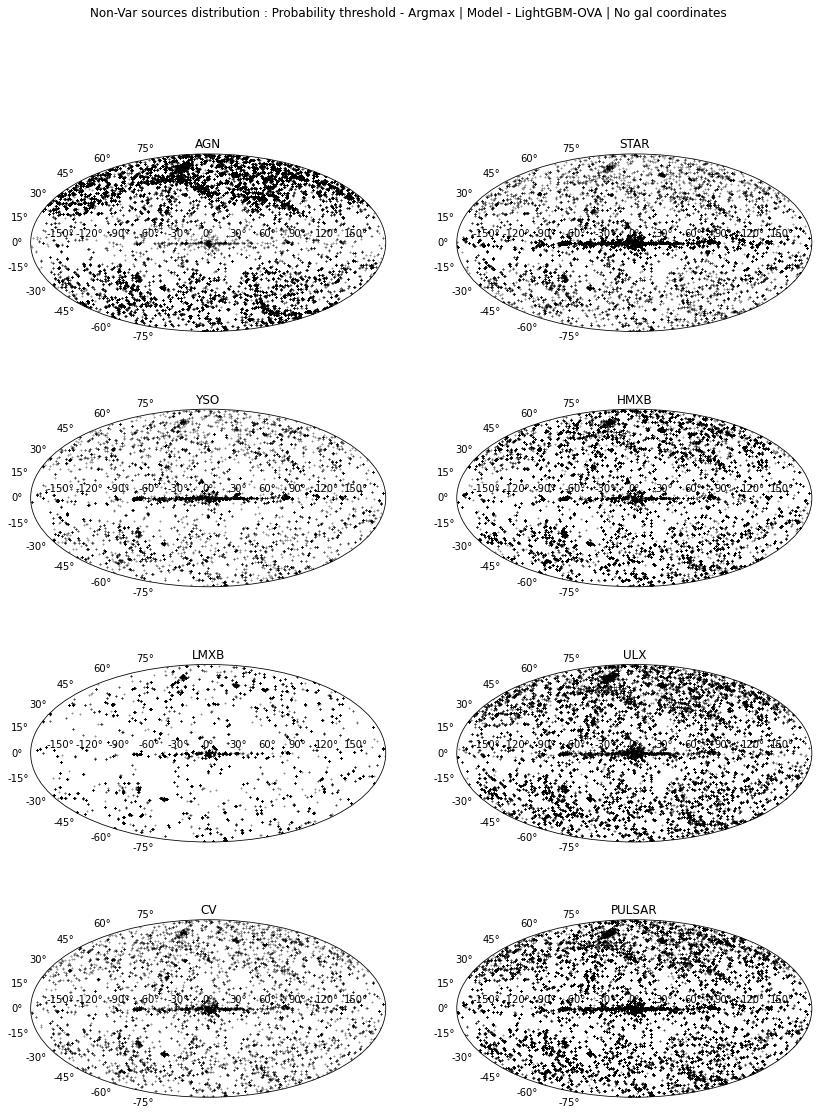

In [81]:
from astropy.coordinates import SkyCoord
from astropy import units as unit 
# plt.figure(figsize=(12,10))
# plt.subplot(111, projection='aitoff' ,)
# plt.grid(True)
colors =['black','lightcoral','lime','fuchsia', 'teal' , 'gold' , 'crimson' , 'indigo']
#fig , ax = plt.subplots(nrows=2, ncols=4 , figsize=(16,10) , projection='aitoff' ,)
k = 0
#cl = np.reshape(classes , ax.shape)
fig = plt.figure(figsize=(14, 18))
for i in range(1,9):
    #cl = classes[k]
    df_plot = u_pos[u_pos['class']==classes[i-1]]
    prob_th = 0.
    df_plot = df_plot[df_plot['prob']>prob_th]
    eq = SkyCoord(df_plot['ra'] , df_plot['dec'] , unit = unit.deg)
    gal = eq.galactic
    ax = fig.add_subplot(int(f'42{i}') , projection='aitoff')
    ax.scatter(gal.l.wrap_at('180d').radian, gal.b.radian , s=1 , marker='x',alpha=0.4 , label=classes[i-1] , color='k')
    ax.set_title(classes[i-1])
    #plt.legend()
fig.suptitle('Non-Var sources distribution : Probability threshold - Argmax | Model - LightGBM-OVA | No gal coordinates')
plt.savefig('plots/all_src_pred/lightgbm_non-var-no-gal.jpg')
plt.show()

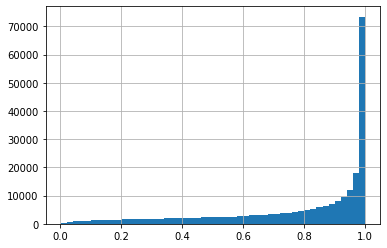

0.9800586875658782

In [82]:
x ,y ,z = plt.hist(u_df['prob'] ,bins=50)
plt.grid()
plt.show()
mode = y[np.argmax(x)]
mode

In [83]:
u_df_num = u_df['class'].value_counts().to_frame()
u_df_num = pd.concat([
                u_df['class'].value_counts() ,
                u_df[u_df['prob']>mode]['class'].value_counts(),
                u_df[u_df['prob']>0.5]['class'].value_counts(),
                u_df[u_df['prob']>0.6]['class'].value_counts(),
                u_df[u_df['prob']>0.7]['class'].value_counts(),
                u_df[u_df['prob']>0.8]['class'].value_counts(),
                u_df[u_df['prob']>0.9]['class'].value_counts(),
                u_df[u_df['prob']>0.98]['class'].value_counts(),
                 ] , axis=1)
u_df_num.columns = ['Argmax' , f"Most probable > {mode :.2f}" ,'0.5' ,'0.6' ,'0.7' ,'0.8' ,'0.9' ,'0.98']
u_df_num.index.name = 'class'
#u_df_num.to_csv(f'temp_res_comp/unid_num/{d_name}_{m_name}.csv')
u_df_num.append(u_df_num.sum() , ignore_index=True)
print(u_df_num.to_markdown())

| class   |   Argmax |   Most probable > 0.98 |   0.5 |   0.6 |   0.7 |   0.8 |   0.9 |   0.98 |
|:--------|---------:|-----------------------:|------:|------:|------:|------:|------:|-------:|
| HMXB    |    47093 |                  10029 | 35725 | 32715 | 29372 | 25448 | 20010 |  10046 |
| AGN     |    47015 |                  25057 | 42394 | 40549 | 37958 | 34547 | 29591 |  25062 |
| PULSAR  |    38795 |                  10348 | 33196 | 31229 | 28664 | 25341 | 20089 |  10364 |
| STAR    |    37955 |                  17099 | 33514 | 32073 | 30355 | 28056 | 24445 |  17112 |
| ULX     |    31791 |                   4911 | 26787 | 24916 | 22487 | 18906 | 13449 |   4919 |
| YSO     |    13324 |                   3704 | 11502 | 10900 | 10102 |  8868 |  7039 |   3710 |
| LMXB    |    12094 |                   1895 |  9149 |  8317 |  7273 |  5999 |  4394 |   1903 |
| CV      |     9109 |                    401 |  6341 |  5554 |  4661 |  3511 |  1968 |    401 |


In [84]:
from numpy.random import normal
from ridgeplot import ridgeplot
cl = classes[::-1]
sample = [u_df[u_df['class']==c]['prob'] for c in cl]
fig = ridgeplot(
    samples=sample,
    kde_points=np.linspace(0, 1, 500),
    colorscale="inferno",
    colormode="index",
    coloralpha=0.6,
    labels=cl,
    spacing = 3 / 8,
    xpad=0
)
fig.update_layout(
    title="Unidentified sources | No Imputation | LightGBM classifier",
    height=550,
    width=600,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    xaxis_title="Predicted Probability",
    yaxis_title="Predicted Probability Density",
)

#fig.save('temp.png')
#fig.write_image('temp_res_comp/unid_prob_dist/lightGBM_none.jpg')
fig.show()

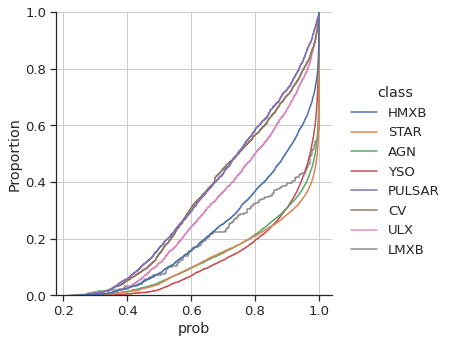

In [ ]:
sns.displot(
    data = u_df ,
    kind='ecdf' ,
    x = 'prob' ,
    hue = 'class'
)
#plt.savefig('plots/higher_models/lbg_unid_prob.jpg')
plt.show()